In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.impute import SimpleImputer

## 0. Load & process the features

In [2]:
# Load the extracted features for Sleep-EDF-SC-78
# Note: to extract the features run the notebook SleepEDF-SC +/- 30min.ipynb

df_feats = pd.read_parquet("../../features/sleep-edf__cassette_features_ALL__90s.parquet")
print(df_feats.shape)

(416271, 366)


In [3]:
# Add some delta's & ratios to the features (just as in SleepEDF-SC +/- 30min.ipynb)

sigs = list(set(c.split("__")[0] for c in df_feats.columns))

eeg_signals = [d for d in sigs if "EEG" in d]
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
for eeg_sig in eeg_signals:
    eeg_bands = [c for c in df_feats.columns if c.startswith(eeg_sig) and c.split("__")[1] in bands]
    windows = sorted(set(b.split("__")[-1] for b in eeg_bands))
    for window in windows:
        # Select the spectral powers
        delta = df_feats["__".join([eeg_sig, "sdelta", window])] + df_feats["__".join([eeg_sig, "fdelta", window])]
        fdelta_theta = df_feats["__".join([eeg_sig, "fdelta", window])] + df_feats["__".join([eeg_sig, "theta", window])]
        alpha = df_feats["__".join([eeg_sig, "alpha", window])]
        beta = df_feats["__".join([eeg_sig, "beta", window])]
        theta = df_feats["__".join([eeg_sig, "theta", window])]
        sigma = df_feats["__".join([eeg_sig, "sigma", window])]
        # Calculate the ratios
        df_feats["__".join([eeg_sig, "fdelta+theta", window])] = fdelta_theta.astype("float32")        

        df_feats["__".join([eeg_sig, "alpha/theta", window])] = (alpha / theta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/beta", window])] = (delta / beta).astype("float32")
        df_feats["__".join([eeg_sig, "delta/sigma", window])] = (delta / sigma).astype("float32")
        df_feats["__".join([eeg_sig, "delta/theta", window])] = (delta / theta).astype("float32")

print(df_feats.shape)

df_feats = df_feats[df_feats.label != "Movement time"]
print(df_feats.shape)
df_feats = df_feats[df_feats.label != "Sleep stage ?"]
print(df_feats.shape)
df_feats["label"] = df_feats.label.apply(lambda x: "Sleep stage 3" if x.endswith("4") else x)
print(df_feats.label.value_counts())

(416271, 396)
(416143, 396)
(414813, 396)
Sleep stage W    285286
Sleep stage 2     69132
Sleep stage R     25835
Sleep stage 1     21521
Sleep stage 3     13039
Name: label, dtype: int64


In [4]:
# Perform the temporal shifts (just as in SleepEDF-SC +/- 30min.ipynb)

feats_30s = [f for f in df_feats.columns if "w=30s" in f]
feats_60s = [f for f in df_feats.columns if "w=1m_" in f]
feats_90s = [f for f in df_feats.columns if "w=1m30s" in f]
print(len(feats_30s), len(feats_60s), len(feats_90s))
dfs = []
for psg_file in df_feats.psg_file.unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]

    sub_df = sub_df.merge(
        sub_df[feats_90s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )
    sub_df = sub_df.drop(columns=feats_90s)

    sub_df = sub_df.merge(
        sub_df[feats_60s].shift(1).add_suffix("_shift=30s"),
        left_index=True,
        right_index=True,
    )

    sub_df = sub_df.merge(sub_df[feats_30s].shift(2).add_suffix("_shift=1m"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(1).add_suffix("_shift=30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-1).add_suffix("_shift=-30s"), left_index=True, right_index=True)
    sub_df = sub_df.merge(sub_df[feats_30s].shift(-2).add_suffix("_shift=-1m"), left_index=True, right_index=True)
    dfs += [sub_df]
df_feats = pd.concat(dfs)
df_feats.shape

131 131 131


(414813, 1051)

In [5]:
# Trim the features to include 30 min of wake time before/after sleep period

def get_repeat_length(val, arr):
    if arr[0] != val:
        return 0
    return np.where(arr != val)[0][0] + 1

dfs = []
for psg_file in df_feats["psg_file"].unique():
    sub_df = df_feats[df_feats.psg_file == psg_file]  # .sort_index()
    labels = sub_df["label"].values
    nb_wake_before_sleep = get_repeat_length("Sleep stage W", labels)
    nb_wake_after_sleep = get_repeat_length("Sleep stage W", labels[::-1])
    start_idx = max(0, nb_wake_before_sleep - 30 * 2)
    end_idx = min(-1, -nb_wake_after_sleep + 30 * 2)
    dfs.append(sub_df[start_idx:end_idx])
df_feats = pd.concat(dfs)

print(df_feats.shape)

(195168, 1051)


In [6]:
feat_cols = [c for c in df_feats.columns if c not in ["label", "psg_file", "patient_id"]]
print(len(feat_cols))

1048


# 1. PCA

In [7]:
# We want to get PCA embedding with 2 dimensions
n_components = 2

pca = PCA(n_components)
pca_result = pca.fit_transform(
    SimpleImputer().fit_transform(df_feats[feat_cols])
)
print(pca_result.shape)

label_col = "label"
pca_result = pd.DataFrame(pca_result).add_prefix("pca_")
pca_result[label_col] = df_feats[label_col].values

(195168, 2)


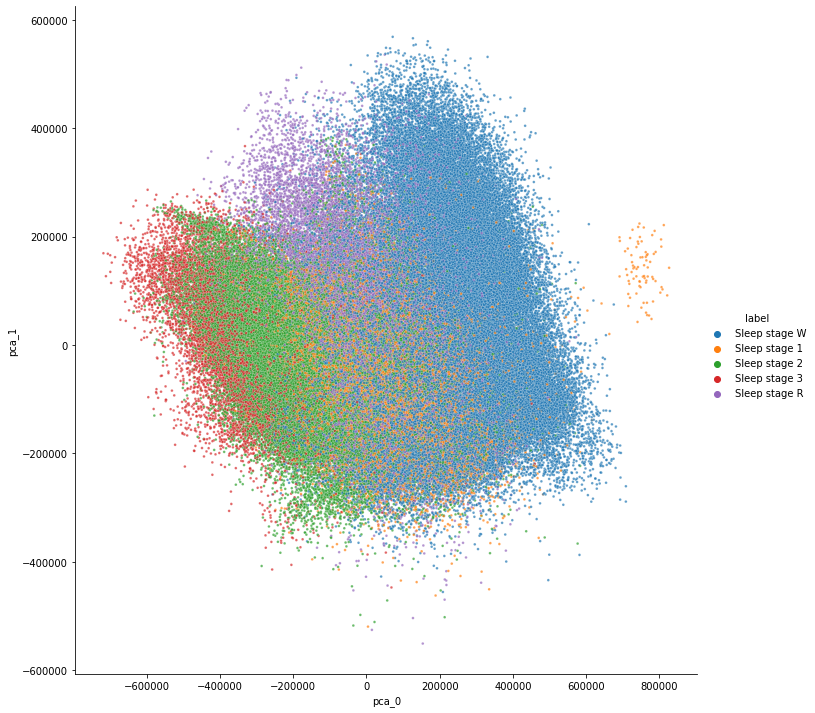

In [8]:
labels = ["Sleep stage W"] + [f"Sleep stage {i}" for i in range(1,4)] + ["Sleep stage R"] 

sns.relplot(
    data=pca_result,
    x="pca_0",
    y="pca_1",
    hue=label_col,
    hue_order=labels,
    height=10,
    kind="scatter",
    s=7,
    alpha=0.7
)

## TSNE

In [9]:
# We want to get TSNE embedding with 2 dimensions
n_components = 2

sample = df_feats.sample(50_000)  # sample 50k rows

tsne = TSNE(n_components, perplexity=50, n_jobs=30, init='pca', learning_rate='auto')
tsne_result = tsne.fit_transform(
    SimpleImputer().fit_transform(sample[feat_cols])
)
print(tsne_result.shape)

label_col = "label"
tsne_result = pd.DataFrame(tsne_result).add_prefix("tsne_")
tsne_result[label_col] = sample[label_col].values

/users/jonvdrdo/jeroen/git/sleep-linear/venv/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


(50000, 2)


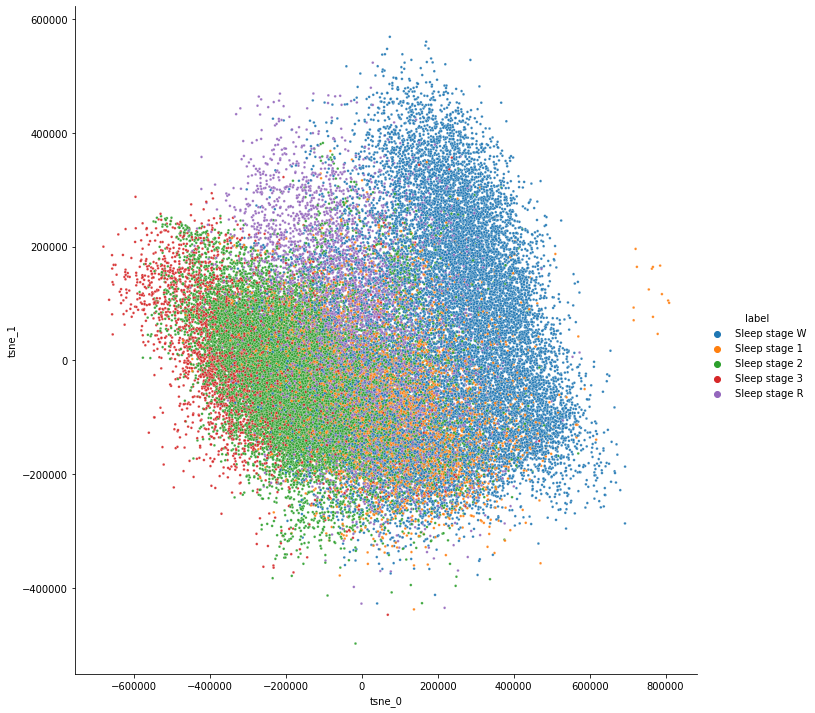

In [10]:
labels = ["Sleep stage W"] + [f"Sleep stage {i}" for i in range(1,4)] + ["Sleep stage R"] 

sns.relplot(
    data=tsne_result,
    x="tsne_0",
    y="tsne_1",
    hue=label_col,
    hue_order=labels,
    height=10,
    kind="scatter",
    s=7,
    alpha=0.9
)